# Using SunPy in the Cloud: Scalable Solar Data Analysis with `sunpy`, `astropy`, and `dask`

In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.io.fits
import astropy.time
from reproject import reproject_adaptive
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
import sunpy.util
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import propagate_with_solar_surface
import ndcube
from sunkit_image.time_lag import time_lag

from dask_gateway import Gateway
from dask.distributed import PipInstall
import dask.array

from net.heliocloud import HelioCloudClient
import net.attrs as heliocloud_attrs

%matplotlib inline

/home/jovyan/users_conda_envs/scipy-2023-talk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Dask Cluster

In [2]:
gateway = Gateway()

In [3]:
options = gateway.cluster_options()
options.worker_cores = 1
options.worker_memory = 8

In [4]:
cluster = gateway.new_cluster(options)

In [5]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.b506f7ce66354acd9fe90c39dae4a87b/status,


In [6]:
pip_plugin = PipInstall(
    packages=[
        "ndcube",
        "sunpy[map]",
        "astropy",
    ],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{}

In [7]:
cluster.adapt(minimum=3, maximum=15)

## Searching for data

First, define the wavelengths we want to search over and the time range

In [8]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')
time_start = midpoint-interval/2
time_end = midpoint+interval/2

In [9]:
q = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(171*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [10]:
q

Dataset,Start time,URL
str3,object,str86
aia,2018-05-29 12:00:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120000_0171_v1.fits
aia,2018-05-29 12:04:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120400_0171_v1.fits
aia,2018-05-29 12:08:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120800_0171_v1.fits
aia,2018-05-29 12:12:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121200_0171_v1.fits
aia,2018-05-29 12:16:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121600_0171_v1.fits
aia,2018-05-29 12:20:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122000_0171_v1.fits
aia,2018-05-29 12:24:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122400_0171_v1.fits
aia,2018-05-29 12:28:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122800_0171_v1.fits
aia,2018-05-29 12:32:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T123200_0171_v1.fits


## Identifying the Active Region

Next, we need to identify where our active region is on the disk.
We do this at a specific time that is approximately the midpoint of our observing interval.
We can then load in our full-disk map, identify the active region of interest, and create the bounding box to make the rest of our cutouts.

In [11]:
i_midpoint = np.argmin(np.fabs((astropy.time.Time(q[0]['Start time']) - midpoint).to_value('s')))

In [12]:
with astropy.io.fits.open(q[0]['URL'][i_midpoint], use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
    header = hdul[1].header
    data = hdul[1].data
ref_map_full_disk = sunpy.map.Map(data, header)

In [13]:
ar_center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=ref_map_full_disk.coordinate_frame)

In [14]:
fov = (500, 500)*u.arcsec

In [15]:
bottom_left = SkyCoord(Tx=ar_center.Tx-fov[0]/2,
                       Ty=ar_center.Ty-fov[1]/2,
                       frame=ref_map_full_disk.coordinate_frame)

To confirm this, we can plot map and the coordinate of the active region center.

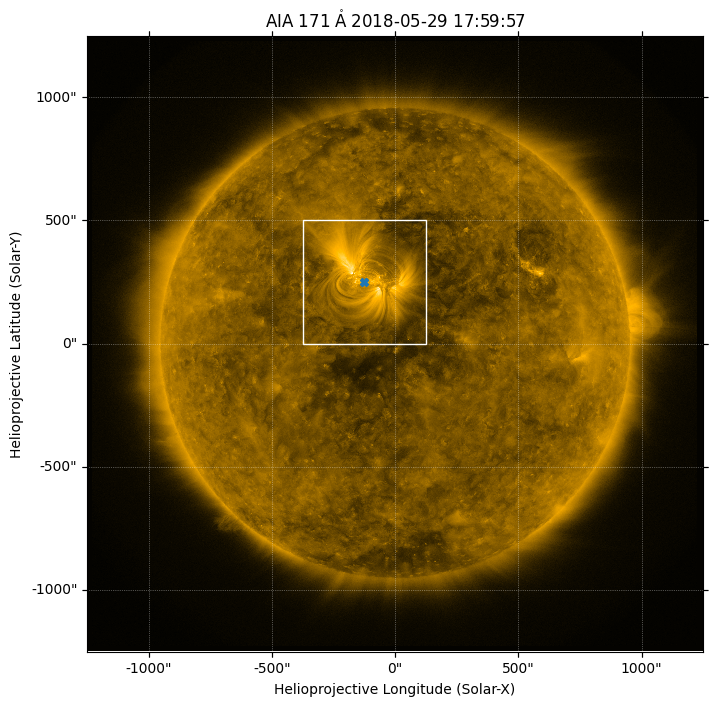

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ref_map_full_disk)
ref_map_full_disk.plot(axes=ax)
ref_map_full_disk.draw_quadrangle(bottom_left, width=fov[0], height=fov[1])
ax.plot_coord(ar_center, marker='X', color='C0')

Next, we want to create a cutout around the active region.
This will help us define our bounding box for the rest of our cutouts.

In [17]:
ref_map_cutout = ref_map_full_disk.submap(bottom_left, width=fov[0], height=fov[1])

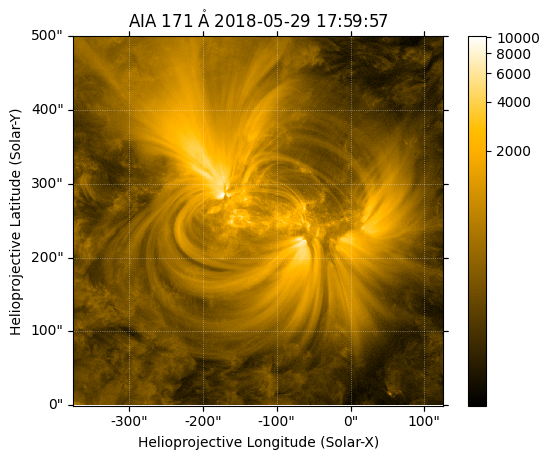

In [18]:
ref_map_cutout.peek()

## Loading Metadata

At its core, a map is just a data array plus a metata object.
To build a map, we require the metadata of each map to be in memory.

We'll define a function that just returns the header from each file and use Dask to return this to the RAM of our notebook environment.
The memory footprint of this is very small and fast to load so doing this eagerly is not an issue.

In [19]:
def get_header(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}, lazy_load_hdus=True) as hdul:
        header = hdul[1].header
    return astropy.io.fits.Header(header)

In [20]:
all_headers = client.gather(client.map(get_header, q[0]['URL']))

From these headers, we can also easily construct the WCS (or world coordinate system) for each map.
Like the headers, these are fast to construct and take little to no memory.

In [21]:
all_wcs = [astropy.wcs.WCS(h) for h in all_headers]

## Building the Map

The data arrays, on the other hand, need to be loaded lazily as Dask arrays.
These are 5K by 5K arrays.
Let's first define a delayed function that returns the data array.

In [22]:
@dask.delayed
def get_data(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        data = hdul[1].data
    return data

Fortunately, our map object works well with Dask arrays so we can just create a Dask array from our delayed object and build all of our maps lazily using just our headers and list of files.

In [23]:
def map_from_delayed(delayed_array, wcs, dtype):
    array = dask.array.from_delayed(delayed_array, wcs.array_shape, dtype=dtype,)
    return ndcube.NDCube(array, wcs=wcs)

In [24]:
full_disk_maps = [map_from_delayed(get_data(f), wcs, ref_map_full_disk.data.dtype) for f,wcs in zip(q[0]['URL'], all_wcs)]

In [25]:
full_disk_maps[0]

NDCube
------
Dimensions: [5000. 5000.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: int32

In [26]:
full_disk_maps[0].data

dask.array<from-value, shape=(5000, 5000), dtype=int32, chunksize=(5000, 5000), chunktype=numpy.ndarray>

## Exposure Time Normalization

Each time the telescope records an image, the shutter is left open for some amount of time known as the exposure time.
This value is stored in the header we pulled into memory.

In [27]:
exposure_times = [h['EXPTIME'] for h in all_headers]*u.s

In general, this amount can vary from one image to the next so we must normalize each individual image according to that exposure time.
This is just a matter of dividing each image through by the exposure time which gives us back a new map whose data is now normalized.

In [28]:
normalized_maps = [m/exp_time for m,exp_time in zip(full_disk_maps, exposure_times)]

In [29]:
normalized_maps[0].data

dask.array<mul, shape=(5000, 5000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

## Aligning and Selecting FOV with Reprojection

In [30]:
@dask.delayed
def reproject_array(input_array, input_wcs, target_wcs):
    with propagate_with_solar_surface():
        out_array = reproject_adaptive((input_array, input_wcs),
                                       target_wcs,
                                       shape_out=target_wcs.array_shape,
                                       roundtrip_coords=False,
                                       return_footprint=False)
    return out_array

In [31]:
def reproject_map(input_map, target_wcs):
    delayed_array = reproject_array(input_map.data, input_map.wcs, target_wcs)
    return map_from_delayed(delayed_array, target_wcs, input_map.data.dtype)

In [32]:
reprojected_maps = [reproject_map(m, ref_map_cutout.wcs) for m in normalized_maps]

## Stacking Images

- stack arrays
- interpolate
- build WCS with common (and uniform) time axis
- return resulting NDCube

Because each filter of the AIA telescope does not take an observation at exactly the same time, we need to interpolate each data cube corresponding each channel to a common time array.

In [33]:
def stack_and_interpolate(cutouts, time_cutouts, time_common):
    # Stack data
    data_stacked = np.stack([c.data for c in cutouts], axis=0)
    # Rechunk along time axis
    data_stacked = data_stacked.rechunk(chunks=data_stacked.shape[:1]+(200, 200))
    # Interpolate to common time
    f_interp = lambda y: interp1d(time_cutouts.to_value('s'), y, axis=0, kind='linear', fill_value='extrapolate')
    data_interp = dask.array.map_blocks(
        f_interp(time_common.to_value('s')),
        data_stacked,
        chunks=time_common.shape+data_stacked.chunks[1:],
        dtype=data_stacked.dtype
    )
    # Add the time axis to our coordinate system
    combined_wcs = cutouts[0].wcs.to_header()
    combined_wcs['CTYPE3'] = 'TIME'
    combined_wcs['CUNIT3'] = 's'
    combined_wcs['CDELT3'] = np.diff(time_common)[0].to_value('s')
    combined_wcs['CRPIX3'] = 1
    combined_wcs['CRVAL3'] = time_common[0].to_value('s')
    combined_wcs = astropy.wcs.WCS(combined_wcs)

    return ndcube.NDCube(data_interp, wcs=combined_wcs, unit=cutouts[0].unit, meta=cutouts[0].meta)

In [34]:
time_171 = astropy.time.Time([w.wcs.dateobs for w in all_wcs])

In [35]:
cadence = 4*u.min
delta_time = time_end - time_start
time_common = time_start + np.arange(0, delta_time.to_value('s'), cadence.to_value('s')) * u.s

In [37]:
cube_171 = stack_and_interpolate(reprojected_maps,
                                     (time_171 - time_common[0]).to('s'),
                                     (time_common-time_common[0]).to('s'))

In [39]:
cube_171.data

dask.array<<scipy.interpolate._interpolate.interp1d object at, shape=(180, 1002, 1002), dtype=float64, chunksize=(180, 200, 200), chunktype=numpy.ndarray>

<WCSAxes: ylabel='Data'>

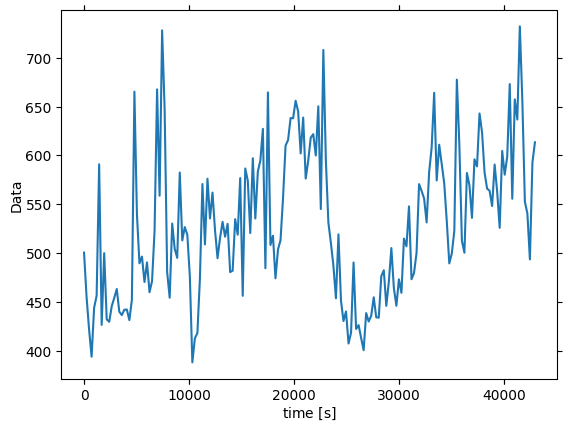

In [40]:
cube_171[:,500,500].plot()

<WCSAxes: >

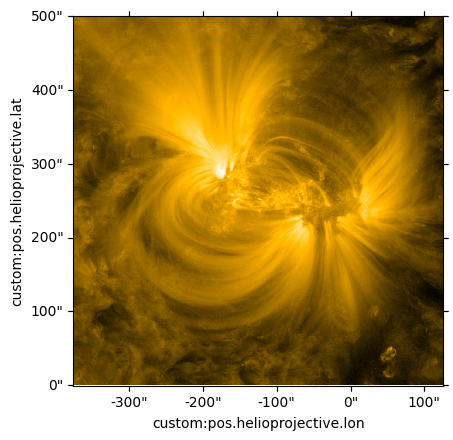

In [33]:
cube_171[0, :, :].plot(**ref_map_cutout.plot_settings)

## Now do this for another channel...

Let's combine all of these steps into a single function

In [44]:
def build_cutout_cube(file_urls, time_common, ref_map):
    all_headers = client.gather(client.map(get_header, file_urls))
    all_wcs = [astropy.wcs.WCS(h) for h in all_headers]
    full_disk_maps = [map_from_delayed(get_data(f), wcs, np.int32) for f,wcs in zip(file_urls, all_wcs)]
    exposure_times = [h['EXPTIME'] for h in all_headers]*u.s
    normalized_maps = [m/exp_time for m, exp_time in zip(full_disk_maps, exposure_times)]
    reprojected_maps = [reproject_map(m, ref_map.wcs) for m in normalized_maps]
    time_maps = astropy.time.Time([w.wcs.dateobs for w in all_wcs])
    cube = stack_and_interpolate(reprojected_maps,
                                 (time_maps - time_common[0]).to('s'),
                                 (time_common-time_common[0]).to('s'))
    return cube

...and apply to this to a set of images from another wavelength.

In [42]:
q_193 = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(193*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [45]:
cube_193 = build_cutout_cube(q_193[0]['URL'], time_common, ref_map_cutout)

For a single pixel, plot the timeseries for the two wavelengths.

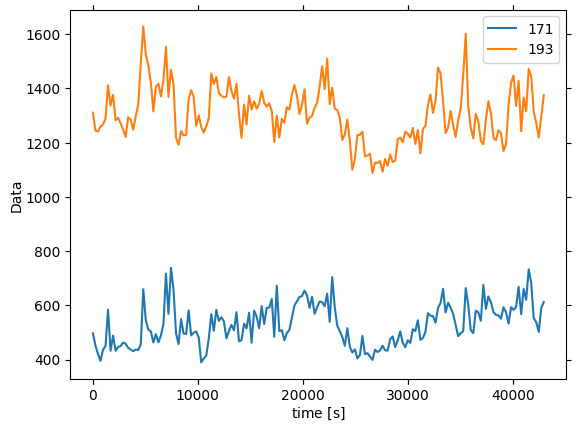

In [94]:
ax = cube_171[:,500,500].plot(label='171')
cube_193[:,500,500].plot(axes=ax, label='193')
ax.legend()

## Time Lag Analysis

Some details on what a time lag is here...

In [47]:
tl_193_171 = time_lag(cube_193.data, cube_171.data, (time_common-time_common[0]).to('s'), [-6,6]*u.h)

In [48]:
tl_193_171

dask.array<mul, shape=(1002, 1002), dtype=float64, chunksize=(35, 1002), chunktype=astropy.Quantity>

Then visualize it

In [49]:
tl_map = ndcube.NDCube(tl_193_171, wcs=ref_map_cutout.wcs)

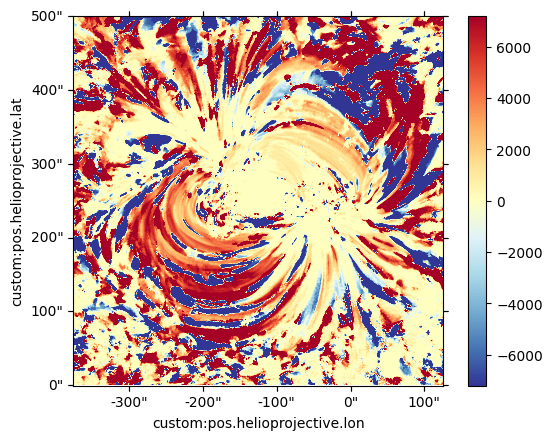

In [50]:
tl_map.plot(cmap='RdYlBu_r', vmin=-7200, vmax=7200)
plt.colorbar()

## Advantages

## Painpoints

- Subsetting does not work on compressed files (though now fixed!)
- There is not an easy way to map a FITS image array into a Dask array and leave the image array on disk
- We have to do a bunch of individual tasks on each map before stacking all the arrays into one cube
    - These individual operations are not "dask aware", e.g. reprojection
    - Necessitates this awkward interface between lower-level functions like `map,submit` and the much more powerful `dask.array` interface
- Incompatibility between xarray and WCS approaches to coordinates systems
- Incompatibility between astropy units and Dask, i.e. cannot have a `Quantity` backed by a Dask array